In [1]:
%load_ext autoreload
%autoreload 2

# TransducedLM vs FusedTransducedLM Benchmark

Compares two approaches to computing next-symbol log-probabilities through
an FST on the Penn Treebank tokenizer (~296 states, 257 input symbols):

- **TransducedLM**: two-phase (PeekabooState BFS decomposition, then LM-weighted search)
- **FusedTransducedLM**: single-pass (interleaved decomposition + LM search, no separate BFS)

Uses a 3-gram CharNgramLM as the inner LM, with per-call timeouts and a
process-wide memory limit.

In [2]:
import time, gc
import numpy as np
from transduction.applications.ptb import build_ptb_fst_pynini, decode_ptb_output
from transduction.fsa import EPSILON
from transduction.util import Timeout, timelimit, set_memory_limit
set_memory_limit(8)

In [3]:
t0 = time.perf_counter()
ptb_fst = build_ptb_fst_pynini()
print(f'PTB FST built in {time.perf_counter()-t0:.1f}s: '
      f'{len(ptb_fst.states)} states, |A|={len(ptb_fst.A)}, |B|={len(ptb_fst.B)}')

Composing PTB rules...
Core PTB FST: 310 states
Final pynini FST: 296 states
Converting to native FST...
Native FST: 296 states, 23723 arcs
  eps: 108 in, 352 out
  MARKER: 0 in, 0 out
  [EOS]: 0 in, 0 out
PTB FST built in 27.3s: 296 states, |A|=257, |B|=256


In [4]:
# Generate target sequence via FST.transduce (PTB FST uses integer byte symbols directly)
text = "The quick brown fox jumps over the lazy dog."
target_seq = list(ptb_fst.transduce(text.encode('utf-8')))
decoded = decode_ptb_output(tuple(target_seq))
print(f'Target: {len(target_seq)} symbols')
print(f'  {decoded!r}')

# Train inner LM on integer byte symbols (CharNgramLM works with any hashable type).
# Each sentence is a separate training instance so the model learns EOS.
from transduction.lm.ngram import CharNgramLM
source_alpha = ptb_fst.A - {EPSILON}
train_sentences = [
    "The quick  brown   fox    jumps     over the lazy dog.",
    "A stitch in time saves nine.",
    "To be or not to be, that is the question.",
    "All that glitters is not gold.",
    "Actions speak louder than words.",
    "Practice makes perfect.",
    "Where there is a will, there is a way.",
] * 3
train_instances = [list(s.encode('utf-8')) for s in train_sentences]
inner_lm = CharNgramLM.train(train_instances, n=3, alpha=0.5, alphabet=source_alpha)
print(f'Inner LM: alphabet={len(inner_lm.alphabet)} symbols')

Target: 45 symbols
  'The quick brown fox jumps over the lazy dog .'
Inner LM: alphabet=257 symbols


In [5]:
decoded

'The quick brown fox jumps over the lazy dog .'

## Decomposition Backend Comparison

Benchmark the raw decomposition step (building Q/R for a target prefix)
across backends:

- **NonrecursiveDFADecomp** — pure-Python powerset + universality
- **PyniniNonrecursiveDecomp** — pynini/OpenFST composition backend
- **RustDecomp** — Rust-accelerated powerset + universality

Each method is called fresh on the same target prefixes at increasing
lengths. Times are best-of-3 to reduce noise.

In [6]:
from transduction.dfa_decomp_nonrecursive import NonrecursiveDFADecomp
from transduction.pynini_ops import PyniniNonrecursiveDecomp, PyniniPrecover
from transduction.rust_bridge import RustDecomp

# Pre-init pynini backend (amortizes FST conversion across targets)
pynini_backend = PyniniPrecover(ptb_fst)

prefix_lengths = [l for l in [3, 5, 8, 10, 15, 20, 30, 40]
                  if l <= len(target_seq)]

methods = [
    ('Standard',  lambda t: NonrecursiveDFADecomp(ptb_fst, t)),
    ('Pynini',    lambda t: PyniniNonrecursiveDecomp(ptb_fst, t, backend=pynini_backend)),
    ('Rust',      lambda t: RustDecomp(ptb_fst, t)),
]

decomp_results = {name: [] for name, _ in methods}

print(f'PTB FST: {len(ptb_fst.states)} states, |A|={len(ptb_fst.A)}, |B|={len(ptb_fst.B)}')
print(f'{"len":>5s}', end='')
for name, _ in methods:
    print(f'  {name:>12s}', end='')
print()
print('-' * (5 + 14 * len(methods)))

for length in prefix_lengths:
    target = tuple(target_seq[:length])
    print(f'{length:5d}', end='')
    for name, fn in methods:
        times = []
        for _ in range(3):
            t0 = time.perf_counter()
            d = fn(target)
            _ = d.quotient
            _ = d.remainder
            times.append(time.perf_counter() - t0)
        best = min(times)
        decomp_results[name].append(best)
        print(f'  {best*1000:10.1f}ms', end='')
    print()

# Summary
std_times = decomp_results['Standard']
print(f'\nSpeedup vs Standard (geomean):')
from math import exp, log
for name in decomp_results:
    if name == 'Standard':
        continue
    ratios = [s / o for s, o in zip(std_times, decomp_results[name]) if o > 0]
    if ratios:
        geo = exp(sum(log(r) for r in ratios) / len(ratios))
        print(f'  {name}: {geo:.1f}x')

PTB FST: 296 states, |A|=257, |B|=256
  len      Standard        Pynini          Rust
-----------------------------------------------
    3       409.5ms         0.7ms        42.2ms
    5       405.0ms         0.6ms        40.3ms
    8       376.8ms         0.7ms        38.6ms
   10      1951.1ms         1.5ms        83.0ms
   15      2703.2ms         5.7ms       116.2ms
   20      2110.9ms         1.6ms        88.9ms
   30       404.2ms         0.8ms        38.8ms
   40      2362.4ms         1.7ms        87.9ms

Speedup vs Standard (geomean):
  Pynini: 773.3x
  Rust: 15.6x


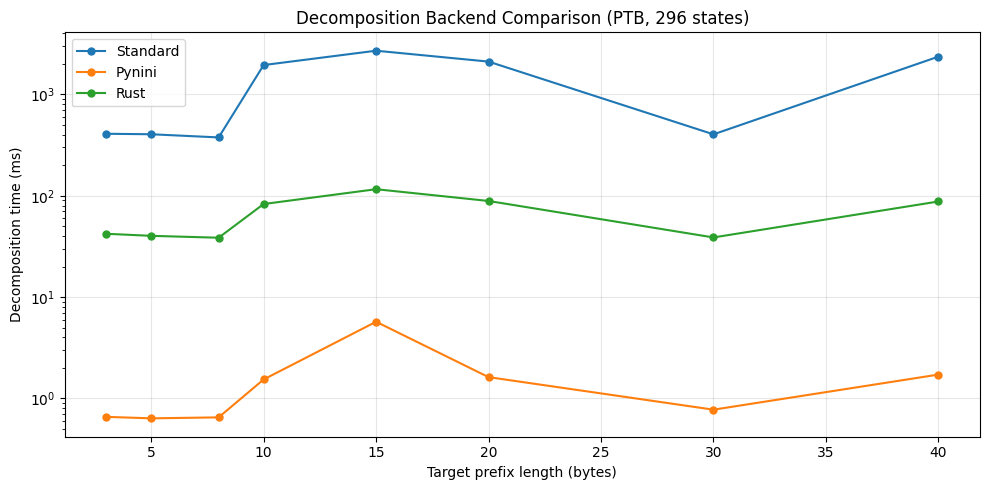

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 5))
for name in decomp_results:
    ax.plot(prefix_lengths, [t * 1000 for t in decomp_results[name]],
            'o-', label=name, markersize=5)
ax.set_xlabel('Target prefix length (bytes)')
ax.set_ylabel('Decomposition time (ms)')
ax.set_title(f'Decomposition Backend Comparison (PTB, {len(ptb_fst.states)} states)')
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_yscale('log')
plt.tight_layout()
plt.show()

## TransducedLM Scaling

Per-step decode time for **TransducedLM** (two-phase: PeekabooState BFS
decomposition, then LM-weighted search) vs **FusedTransducedLM** (single-pass:
interleaved decomposition + LM search, no separate BFS).

Each step includes both decomposition and LM search costs.  For TransducedLM,
the PeekabooState BFS dominates (~35s per step on PTB).  FusedTransducedLM
avoids the BFS entirely but builds the lazy DFA inline during search.

Both use `K=20`, `max_expansions=200`, with a 120s timeout per step.

In [8]:
from collections import defaultdict
from transduction.lm.transduced import TransducedLM
from transduction.lm.fused_transduced import FusedTransducedLM

MAX_DECODE = 100             # number of decode steps
MAX_SEARCH = 200             # max priority-queue steps per logp_next
MAX_BEAM = 20                # max particles carried forward
LM_TIMEOUT = 3               # seconds per step

lm_results = defaultdict(list)  # name -> [(step, time_s, logp)]

for name, cls in [
    ('TransducedLM', TransducedLM),
#    ('FusedTransducedLM', FusedTransducedLM),
]:
    print(f'\n{name} (K={MAX_BEAM}, max_expansions={MAX_SEARCH}):')
    if cls is TransducedLM:
        tlm = cls(inner_lm, ptb_fst, K=MAX_BEAM, max_expansions=MAX_SEARCH)
    else:
        tlm = cls(inner_lm, ptb_fst, max_steps=MAX_SEARCH, max_beam=MAX_BEAM)
    try:
        with timelimit(LM_TIMEOUT):
            state = tlm.initial()
    except (Timeout, MemoryError) as e:
        print(f'  initial() failed: {type(e).__name__}: {e}')
        continue
    for i in range(min(MAX_DECODE, len(target_seq))):
        y = target_seq[i]
        try:
            with timelimit(LM_TIMEOUT):
                t0 = time.perf_counter()
                lp = state.logp_next[y]
                state = state >> y
                t1 = time.perf_counter()
        except Timeout:
            print(f'  step {i+1} TIMEOUT ({LM_TIMEOUT}s)')
            break
        except MemoryError:
            print(f'  step {i+1} OOM')
            break
        elapsed = t1 - t0
        lm_results[name].append((i + 1, elapsed, lp))
        print(f'  {i+1:2d}: {elapsed*1000:8.1f} ms  logp={lp:.4f}')
    gc.collect()


TransducedLM (K=20, max_expansions=200):
   1:     98.1 ms  logp=-4.9127
   2:     33.6 ms  logp=-3.6376
   3:     31.4 ms  logp=-3.6147
   4:    272.2 ms  logp=-2.0268
   5:    147.3 ms  logp=-3.8354
   6:     42.2 ms  logp=-3.0096
   7:     30.1 ms  logp=-3.6253
   8:     29.3 ms  logp=-3.6022
   9:     31.8 ms  logp=-3.6253
  10:    127.9 ms  logp=-2.3400
  11:     72.0 ms  logp=-6.4413
  12:     53.1 ms  logp=-3.6464
  13:     55.5 ms  logp=-3.6006
  14:     64.8 ms  logp=-3.6006
  15:    124.7 ms  logp=-3.6081
  16:    152.5 ms  logp=-1.7654
  17:    294.8 ms  logp=-6.0324
  18:    121.0 ms  logp=-3.5980
  19:    123.7 ms  logp=-3.5986
  20:    239.8 ms  logp=-2.3572
  21:    331.2 ms  logp=-5.7875
  22:    130.5 ms  logp=-3.5977
  23:    117.4 ms  logp=-3.5977
  24:    117.7 ms  logp=-3.5973
  25:    198.9 ms  logp=-3.5973
  26:    249.8 ms  logp=-2.3609
  27:    222.1 ms  logp=-5.9595
  28:    133.1 ms  logp=-3.6204
  29:    250.4 ms  logp=-3.5980
  30:    123.3 ms  logp=-3.620

In [9]:
# Approximate posterior distribution over source strings given the target prefix.
# TransducedState._repr_html_ groups particles by (source, DFA state),
# normalizes log-weights, and renders an HTML table.
state

Source prefix,DFA state,Role,Count,log w,p(x|y)
'The quick brown fox jumps over the lazy dog.',"{(110, (84,104,101,258…)), (55, (84,104,101,258…))}",frontier,1,-162.52,0.6177
'The quick brown fox jumps over the lazy dog.',"{(110, (84,104,101,258…)), (55, (84,104,101,258…))}",frontier,1,-164.39,0.0955
'The quick brown fox jumps over the lazy dog.',"{(110, (84,104,101,258…)), (55, (84,104,101,258…))}",frontier,1,-164.39,0.0955
'The quick brown fox jumps over the lazy dog.',"{(110, (84,104,101,258…)), (55, (84,104,101,258…))}",frontier,1,-164.39,0.0955
'The quick brown fox jumps over the lazy dog.',"{(110, (84,104,101,258…)), (55, (84,104,101,258…))}",frontier,1,-164.39,0.0955
'The quick brown fox jumps over the lazy dog .',"{(110, (84,104,101,258…)), (54, (84,104,101,258…)), (55, (84,104,101,258…))}",frontier,1,-170.80,0.0002
'The quick brown fox jumps over the lazy dog .',"{(110, (84,104,101,258…)), (54, (84,104,101,258…)), (55, (84,104,101,258…))}",frontier,1,-172.45,0.0000
'The quick brown fox jumps over the lazy dog .',"{(110, (84,104,101,258…)), (54, (84,104,101,258…)), (55, (84,104,101,258…))}",frontier,1,-172.45,0.0000
'The quick brown fox jumps over the lazy dog .',"{(110, (84,104,101,258…)), (54, (84,104,101,258…)), (55, (84,104,101,258…))}",frontier,1,-172.67,0.0000
'The quick brown fox jumps over the lazy dog .',"{(110, (84,104,101,258…)), (54, (84,104,101,258…)), (55, (84,104,101,258…))}",frontier,1,-172.67,0.0000


## Particle Inspection

Each particle tracks a DFA state ID (an opaque `u32` integer from the Rust
powerset construction), an LM state, and a log-weight.

In [10]:
from transduction.viz import _format_source_path

print(f'{len(state._particles)} particles\n')
for i, p in enumerate(state._particles):
    source = _format_source_path(p.lm_state)
    print(f'  particle {i}: dfa_id={p.dfa_state}  w={p.log_weight:.3f}')
    print(f'    source: {source!r}')

12 particles

  particle 0: dfa_id=50158  w=-162.525
    source: 'The quick brown fox jumps over the lazy dog.'
  particle 1: dfa_id=50158  w=-164.392
    source: 'The quick brown  fox jumps over the lazy dog.'
  particle 2: dfa_id=50158  w=-164.392
    source: 'The quick brown fox  jumps over the lazy dog.'
  particle 3: dfa_id=50158  w=-164.392
    source: 'The quick  brown fox jumps over the lazy dog.'
  particle 4: dfa_id=50158  w=-164.392
    source: 'The quick brown fox jumps  over the lazy dog.'
  particle 5: dfa_id=50555  w=-170.804
    source: 'The quick brown fox jumps over the lazy dog .'
  particle 6: dfa_id=50241  w=-172.452
    source: 'The quick brown fox jumps over the lazy dog  .'
  particle 7: dfa_id=50555  w=-172.452
    source: 'The quick brown fox jumps over the lazy dog  .'
  particle 8: dfa_id=50555  w=-172.671
    source: 'The quick  brown fox jumps over the lazy dog .'
  particle 9: dfa_id=50555  w=-172.671
    source: 'The quick brown fox jumps  over the lazy 

In [16]:
assert len({x.source_path for x in state._particles}) == len(state._particles), (
    "There are duplicate particles, which means there is double-counting! " 
    f"({len(set(x.source_path for x in state._particles))} != {len(state._particles)})"
)
# TODO: There is a stronger invariant worth checking here: none of the particles should be prefixes of one another.

AssertionError: There are duplicate particles, which means there is double-counting! (11 != 12)

In [41]:
#from arsenal import groupby2
#G = groupby2(state._particles, lambda x: x.source_path)
#collisions = []
#for s in G:
#    if len(G[s]) > 1:
#        collisions.append(G[s])

In [42]:
#collisions[0][0].log_weight, collisions[0][1].log_weight

### Q/R FSA Visualization

For each target symbol `y`, the decomposition produces a **quotient** FSA Q(y)
(accepts source prefixes where *all* continuations produce `y` next) and a
**remainder** FSA R(y) (the leftover after removing the quotient).

Below we render Q and R for a few symbols, highlighting particle states in
blue.  States are labeled with their decoded NFA sets.

In [11]:
from IPython.display import display, HTML, SVG

particle_states = {p.dfa_state for p in state._particles}

def fmt_node(s):
    return str(s)

def sty_node(s):
    if s in particle_states:
        return {'fillcolor': '#ADD8E6', 'style': 'filled,rounded'}
    return {}

# Q/R visualization requires a PeekabooState (TransducedState only)
if hasattr(state, '_peekaboo_state'):
    ps = state._peekaboo_state
    decomp = ps.decomp
    shown = 0
    MAX_SHOW = 5
    for y in sorted(decomp.keys(), key=repr):
        if shown >= MAX_SHOW:
            break
        try:
            q_fsa, r_fsa = ps.build_qr_fsa(y)
        except Exception:
            continue
        if not q_fsa.states and not r_fsa.states:
            continue

        y_label = repr(y)
        display(HTML(f'<h4>y = {y_label}</h4>'))
        if q_fsa.states:
            display(HTML(f'<b>Q({y_label})</b> — {len(q_fsa.states)} states'))
            g = q_fsa.graphviz(fmt_node=fmt_node, sty_node=sty_node)
            display(SVG(g._repr_image_svg_xml()))
        if r_fsa.states:
            display(HTML(f'<b>R({y_label})</b> — {len(r_fsa.states)} states'))
            g = r_fsa.graphviz(fmt_node=fmt_node, sty_node=sty_node)
            display(SVG(g._repr_image_svg_xml()))
        shown += 1

    if shown == 0:
        print('No non-trivial Q/R FSAs for current decomposition symbols.')
else:
    print('Q/R FSA visualization not available for FusedTransducedState '
          '(no pre-computed decomposition).')

In [12]:
# Most likely next symbols from this state
logp = state.logp_next
syms = sorted(logp.keys(), key=lambda s: logp[s], reverse=True)[:15]
print(f"{'symbol':>8s}  {'char':>6s}  {'logp':>8s}  {'prob':>8s}")
print("-" * 36)
for s in syms:
    if isinstance(s, int):
        ch = chr(s) if 32 <= s <= 126 else f'\\x{s:02x}'
    else:
        ch = repr(s)
    print(f"{str(s):>8s}  {ch:>6s}  {logp[s]:8.4f}  {np.exp(logp[s]):8.4f}")

  symbol    char      logp      prob
------------------------------------
   <EOS>  '<EOS>'   -1.9319    0.1449
     258   \x102   -2.7077    0.0667
       0    \x00   -5.6931    0.0034
      49       1   -5.6931    0.0034
      24    \x18   -5.6931    0.0034
      97       a   -5.6931    0.0034
     119       w   -5.6931    0.0034
     226    \xe2   -5.6931    0.0034
      75       K   -5.6931    0.0034
     163    \xa3   -5.6931    0.0034
     201    \xc9   -5.6931    0.0034
      50       2   -5.6931    0.0034
     245    \xf5   -5.6931    0.0034
      13    \x0d   -5.6931    0.0034
     176    \xb0   -5.6931    0.0034


In [13]:
# Summary table
print(f'\n{"Algorithm":<25s} {"Total (s)":>10s} {"Avg/step (s)":>12s} {"Steps":>6s}')
print('-' * 55)
for name, data in sorted(lm_results.items()):
    total = sum(t for _, t, _ in data)
    avg = total / len(data)
    print(f'{name:<25s} {total:10.1f} {avg:12.1f} {len(data):6d}')
if len(lm_results) == 2:
    names = sorted(lm_results.keys())
    d0, d1 = lm_results[names[0]], lm_results[names[1]]
    t0 = sum(t for _, t, _ in d0)
    t1 = sum(t for _, t, _ in d1)
    if t1 > 0:
        print(f'\nFused speedup (overall): {t0/t1:.2f}x')
    # Exclude step 1 (amortization penalty for Fused)
    if len(d0) > 1 and len(d1) > 1:
        t0_skip1 = sum(t for _, t, _ in d0[1:])
        t1_skip1 = sum(t for _, t, _ in d1[1:])
        if t1_skip1 > 0:
            print(f'Fused speedup (step 2+): {t0_skip1/t1_skip1:.2f}x')


Algorithm                  Total (s) Avg/step (s)  Steps
-------------------------------------------------------
TransducedLM                     6.1          0.1     45


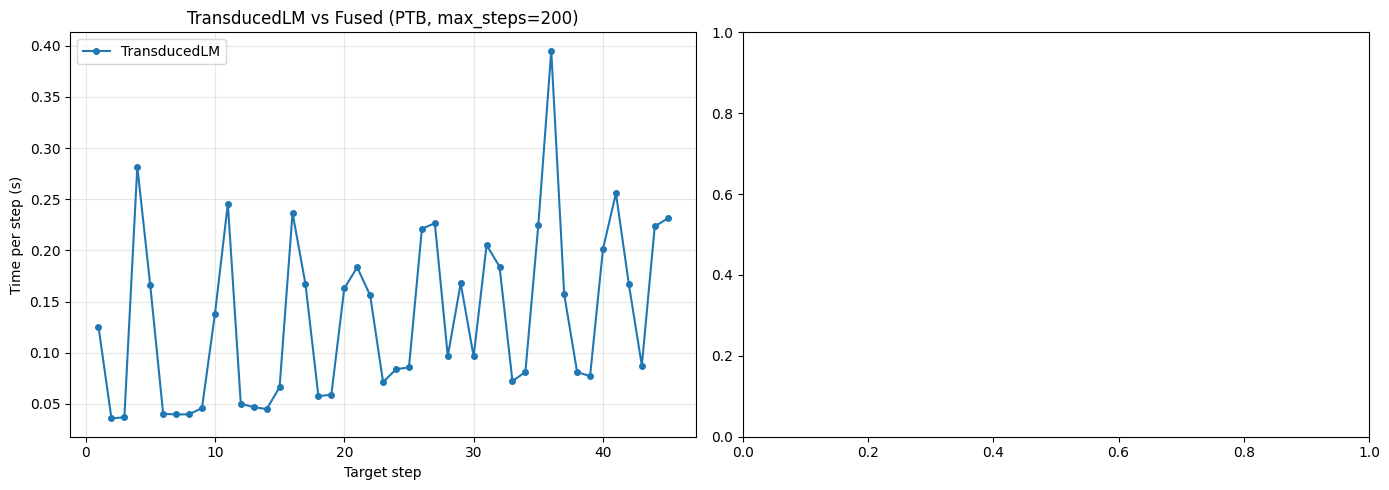

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: time per step
ax = axes[0]
for name, data in sorted(lm_results.items()):
    steps = [d[0] for d in data]
    times = [d[1] for d in data]
    ax.plot(steps, times, 'o-', label=name, markersize=4)
ax.set_xlabel('Target step')
ax.set_ylabel('Time per step (s)')
ax.set_title(f'TransducedLM vs Fused (PTB, max_steps={MAX_SEARCH})')
ax.legend()
ax.grid(True, alpha=0.3)

# Right: per-step speedup
ax = axes[1]
if len(lm_results) == 2:
    names = sorted(lm_results.keys())
    d0, d1 = lm_results[names[0]], lm_results[names[1]]
    n = min(len(d0), len(d1))
    steps = [d0[i][0] for i in range(n)]
    speedups = [d0[i][1] / d1[i][1] if d1[i][1] > 0 else 0 for i in range(n)]
    colors = ['#2ecc71' if s > 1 else '#e74c3c' for s in speedups]
    ax.bar(steps, speedups, color=colors, alpha=0.7, edgecolor='white')
    ax.axhline(1.0, color='black', linestyle='--', linewidth=0.8)
    ax.set_xlabel('Target step')
    ax.set_ylabel('Speedup (Original / Fused)')
    ax.set_title('Per-step speedup (>1 = Fused faster)')
    ax.grid(True, alpha=0.3, axis='y')

    logp_diffs = [abs(d0[i][2] - d1[i][2]) for i in range(n)]
    print(f'Max |logp| diff: {max(logp_diffs):.6f}')

plt.tight_layout()
plt.show()